In [1]:
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt

The `ActionModelUnicycle()` can be found [here](https://gitlab.iri.upc.edu/jmarti/crocoddyl/-/blob/master/crocoddyl/unicycle.py)

```python
class ActionModelUnicycle:
    def __init__(self):
        '''
        Transition model is xnext(x,u) = Fx*x + Fu*x.
        Cost model is cost(x,u) = 1/2 [x,u].T [Lxx Lxu ; Lxu.T Luu ] [x,u] + [Lx,Lu].T [x,u].
        '''
        self.State = StateVector(3)
        self.nx = self.State.nx
        self.ndx = self.State.ndx
        self.nu = 2
        self.ncost = 5

        self.dt = 0.1
        self.costWeights = [1, 0.03]
        self.unone = np.zeros(self.nu)

    def createData(self):
        return ActionDataUnicycle(self)
    
    def calc(model, data, x, u=None):
        if u is None: 
            u = model.unone
            
        assert(x.shape == (model.nx,) and u.shape == (model.nu,))
        assert(data.xnext.shape == (model.nx,))
        assert(data.costResiduals.shape == (model.ncost,))
        
        v, w = u
        c, s = np.cos(x[2]), np.sin(x[2])
        dx = np.array([v*c, v*s, w])
        data.xnext[:] = [x[0]+c*v*model.dt, x[1]+s*v*model.dt, x[2]+w*model.dt]
        data.costResiduals[:3] = model.costWeights[0] * x
        data.costResiduals[3:5] = model.costWeights[1] * u
        data.cost = .5 * sum(data.costResiduals**2)
        
        return data.xnext, data.cost

    def calcDiff(model, data, x, u=None):
        if u is None: 
            u = model.unone
            
        xnext, cost = model.calc(data, x, u)

        ### Cost derivatives
        data.L[:] = np.diag([model.costWeights[0]] * model.nx + [model.costWeights[1]] * model.nu)
        data.Lx[:] = x * ([model.costWeights[0]**2] * model.nx)
        data.Lu[:] = u * ([model.costWeights[1]**2] * model.nu)
        np.fill_diagonal(data.Lxx, model.costWeights[0]**2)
        np.fill_diagonal(data.Luu, model.costWeights[1]**2)

        ### Dynamic derivatives
        c, s, dt = np.cos(x[2]), np.sin(x[2]), model.dt
        v, w = u
        data.Fx[:] = [[1, 0, -s*v*dt],
                      [0, 1, c*v*dt],
                      [0, 0, 1]]
        data.Fu[:] = [[c*model.dt, 0],
                      [s*model.dt, 0],
                      [0, model.dt]]
        
        return xnext, cost

    
class ActionDataUnicycle:
    def __init__(self, model):
        nx, nu, ncost = model.nx, model.nu, model.ncost
        
        self.L = np.zeros([nx+nu, nx+nu])
        self.g = np.zeros([nx+nu])
        self.F = np.zeros([nx,nx+nu])

        self.cost = np.nan
        self.xnext = np.zeros([nx])
        self.costResiduals = np.zeros([ncost])  # Might be use for numdiff (Gauss-Newton appox)

        self.Lxx = self.L[:nx, :nx]
        self.Lxu = self.L[:nx, nx:]
        self.Lux = self.L[nx:, :nx]
        self.Luu = self.L[nx:, nx:]
        self.Lx = self.g[:nx]
        self.Lu = self.g[nx:]
        self.Fx = self.F[:, :nx]
        self.Fu = self.F[:, nx:]
```

In [2]:
model = crocoddyl.ActionModelUnicycle()
data = model.createData()

model.costWeights = np.matrix([
    10,   # state weight
    1    # control weight
]).T

`crocoddyl.ShootingProblem()`: Declare a shooting problem.

A shooting problem declares the initial state, a set of running action models and a terminal action model. It has three main methods - `calc`, `calcDiff` and `rollout`. 
- `calc()`: computes the set of next states and cost values per each action model. 
- `calcDiff()`: updates the derivatives of all action models. 
- `rollout()`: rollouts the stacks of actions models.

Init docstring:
```python
__init__( 
    (object)self, 
    (numpy.ndarray)x0, 
    (StdVec_ActionModel)runningModels, 
    (ActionModelAbstract)terminalModel
) -> None:  # Initialize the shooting problem and allocate its data.
    
    :param x0: initial state
    :param runningModels: running action models (size T)
    :param terminalModel: terminal action model
```

In [3]:
x0 = np.matrix([-1., -1., 1.]).T  # x, y, theta
T = 20
problem = crocoddyl.ShootingProblem(x0, [model] * T, model)

Here we define a problem starting from $\mathbf{x}_0$ with 20 timesteps (of 0.1 sec by default implementation of unicycle). The terminal action model is defined using the running action model. This defines the model, not any algorithm to solve it. The only computation that the problem can provide is to integrate the system for a given sequence of controls.

In [4]:
states = []
controls = []

# Define DDP problem
ddp = crocoddyl.SolverDDP(problem)

for i in range(100):
    # Solve DDP problem
    ddp.solve()
    
    # Get next state
    xs = problem.rollout(ddp.us)
    
    # Set next state to current state
    ddp.problem.x0 = xs[1]
    
    # Store data
    states.append(xs[0])
    controls.append(ddp.us.tolist()[0])

### Plot Unicycle Motion

In [5]:
def plotUnicycle(x, ax):
    sc, delta = .1, .1
    a, b, th = x[0].item(), x[1].item(), x[2].item()
    c, s = np.cos(th), np.sin(th)
    refs = [
        ax.arrow(a - sc / 2 * c - delta * s, b - sc / 2 * s + delta * c, c * sc, s * sc, head_width=.05),
        ax.arrow(a - sc / 2 * c + delta * s, b - sc / 2 * s - delta * c, c * sc, s * sc, head_width=.05)
    ]
    return refs


def plotUnicycleSolution(xs, figIndex=1, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for x in xs:
        plotUnicycle(x, ax)
    
    ax.axis([-1.5, 0.5, -1.5, 0.5])
    ax.grid()
    
    if show:
        plt.show()

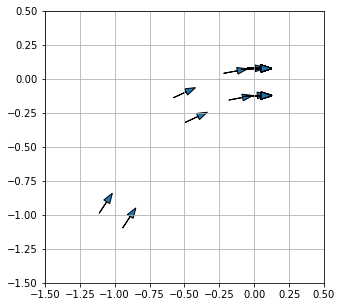

In [6]:
plotUnicycleSolution(states)

In [13]:
? crocoddyl.CostModelResidual